Паркинсоновата болест е прогресивно невролошко нарушување кое влијае на движењето. Вкочанетост, тремор и забавување на движењата може да бидат знаци на Паркинсонова болест. Со користење на модели на машинско учење може да ја предвидиме Паркинсоновата болест.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from tqdm.notebook import tqdm
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix,classification_report,precision_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

Вчитување на податочното множество и запознавање со истото.

In [5]:
df = pd.read_csv('parkinsons.data')

За подобро да го разбереме множеството податоци, користиме некои вградени функции од библиотеката Pandas. Овие функции ни помагаат да ја провериме структурата, типовите на податоци и статистичките својства на множеството податоци.

- df.info(): Го прикажува вкупниот број на редови и колони, типовите на податоци на секоја колона и бројот на не-нулти вредности. Ова помага да се идентификуваат недостасувачките податоци и типовите на колони.
- df.describe().T: Обезбедува транспониран статистички преглед на нумерички колони, вклучувајќи ја средната вредност, стандардната девијација, минималните и максималните вредности, како и квартили. Ова ни помага да ја разбереме распределбата на податоците.
- df.isnull().sum().sum(): Го проверува вкупниот број на недостасувачки вредности во множеството податоци. Ако ова врати 0, тоа значи дека нема недостасувачки вредности. Ако има нулти/недостасувачки вредности, тогаш започнуваме со процесот на чистење на податоци за да ги обработиме тие вредности.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [10]:
df.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,...,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,...,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,...,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,...,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,...,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,...,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,...,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


In [12]:
df.isnull().sum()

name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64

<Axes: >

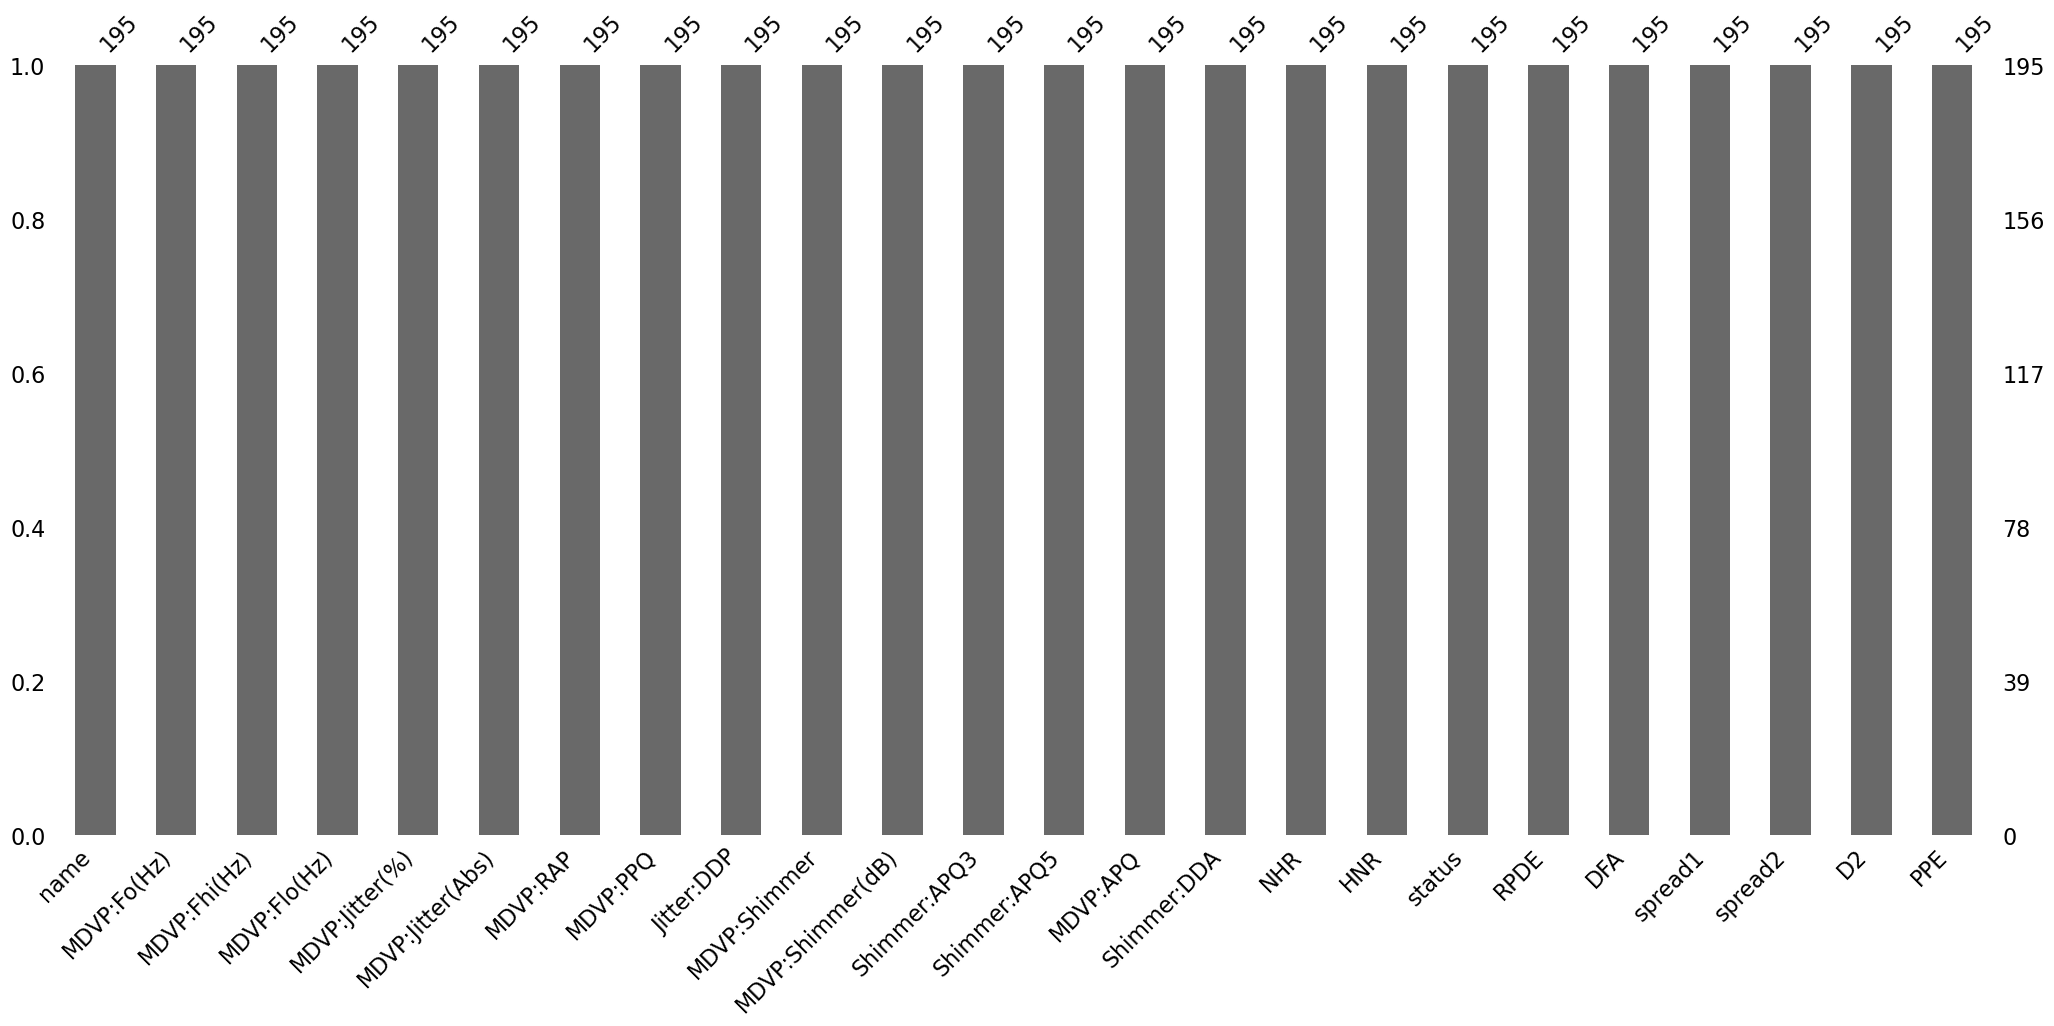

In [14]:
msno.bar(df)

<Axes: >

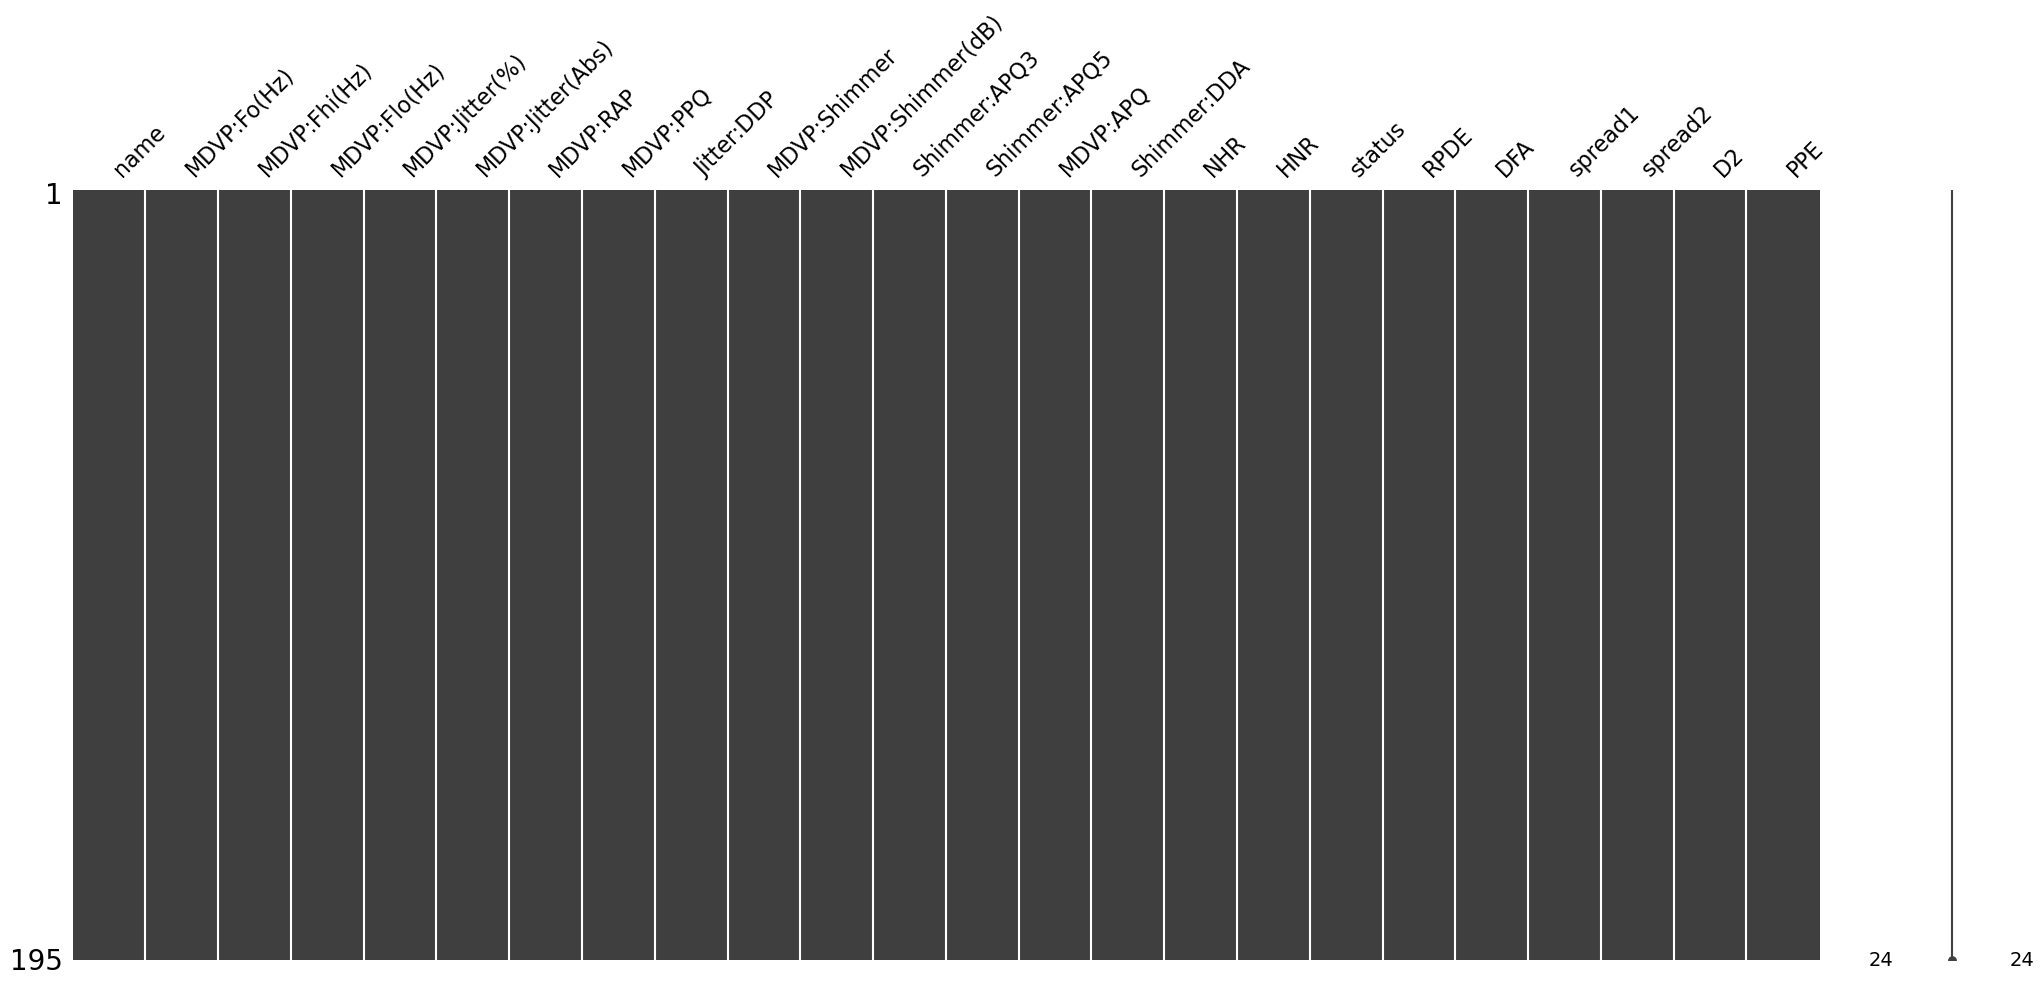

In [16]:
msno.matrix(df)

Бидејќи нема missing values, нема потреба од чистење на податоците.

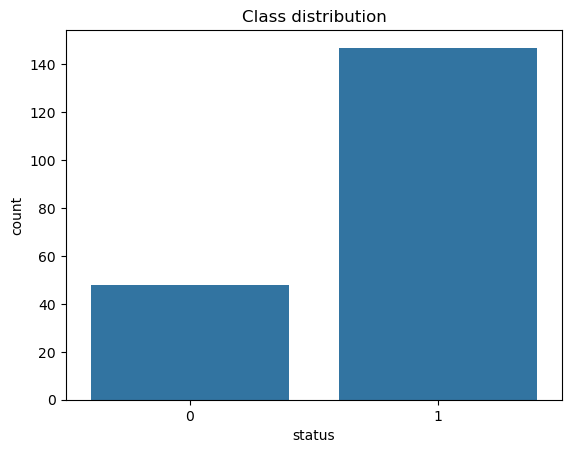

In [19]:
#Анализа на таргет променливата
sns.countplot(x='status', data=df)
plt.title('Class distribution')
plt.show()

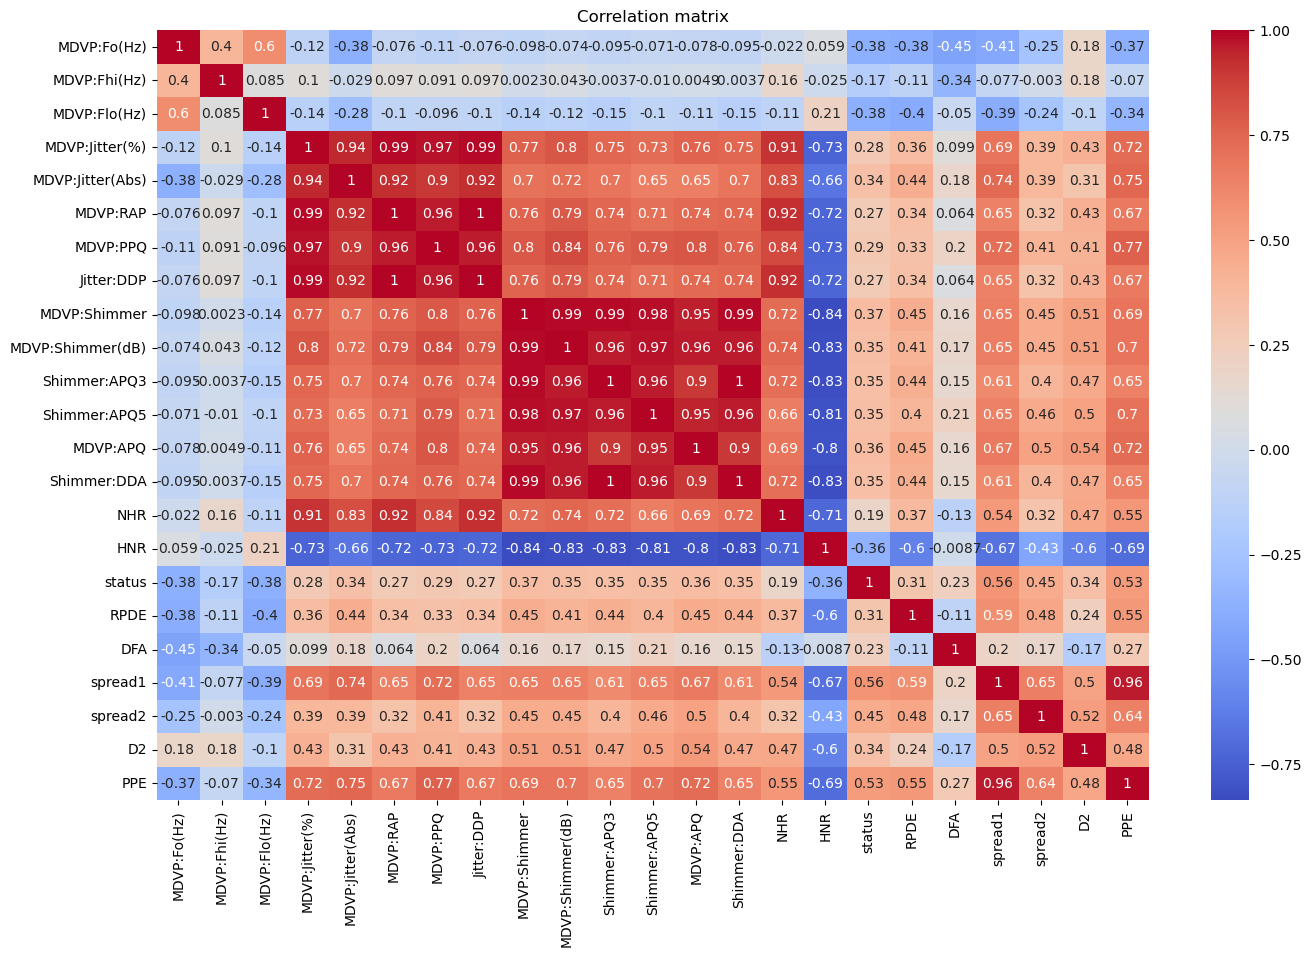

In [21]:
plt.figure(figsize=(16, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

In [27]:
#Drop na kolonata ID
df = df.drop(columns=['name'])

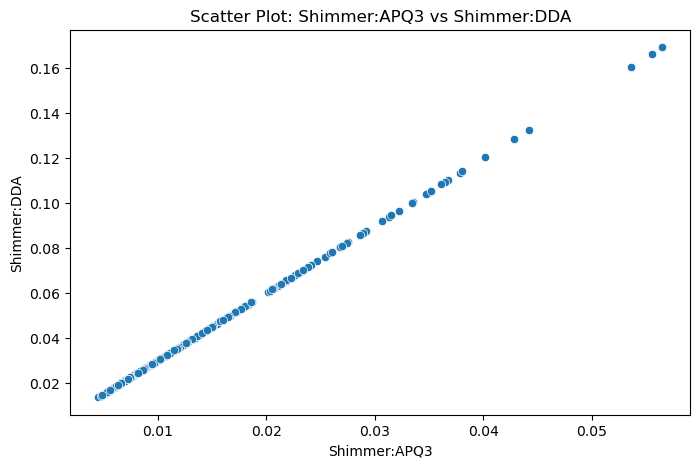

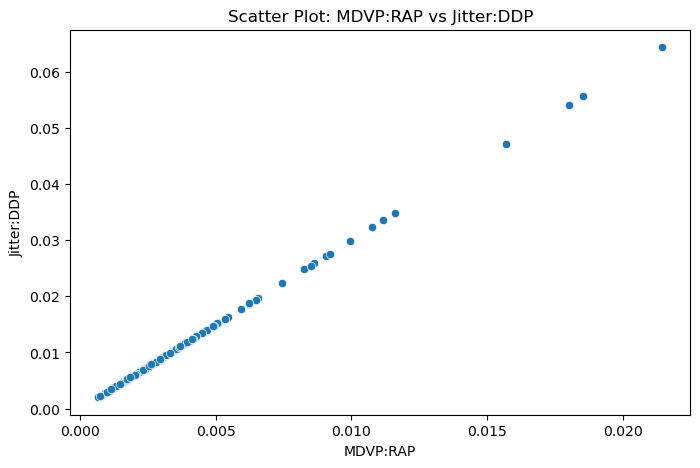

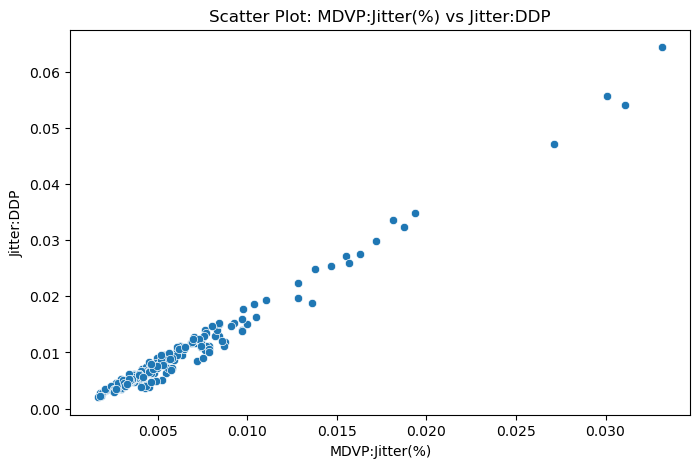

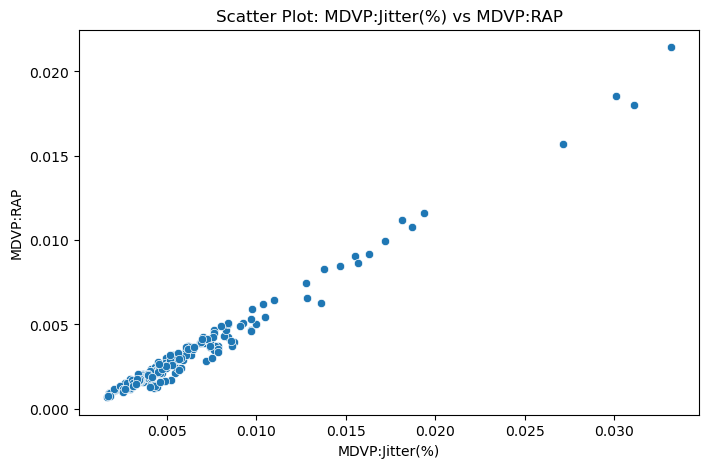

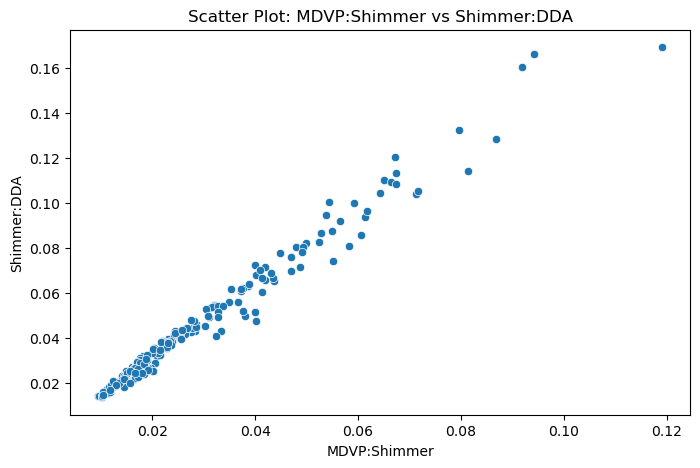

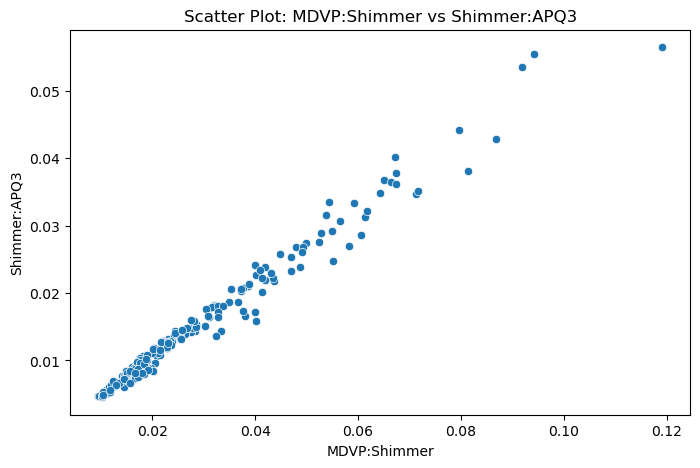

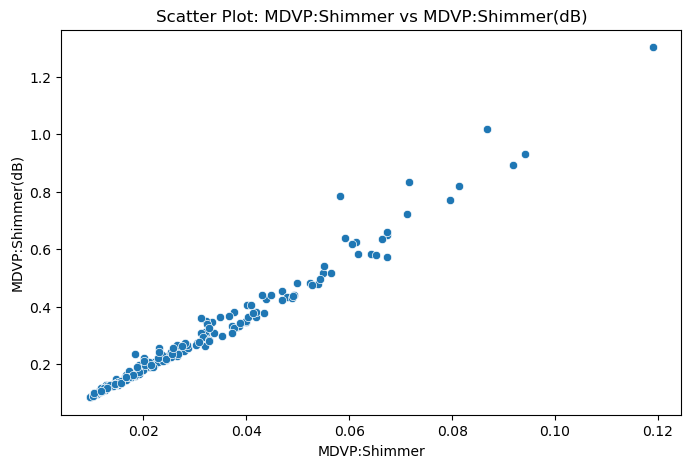

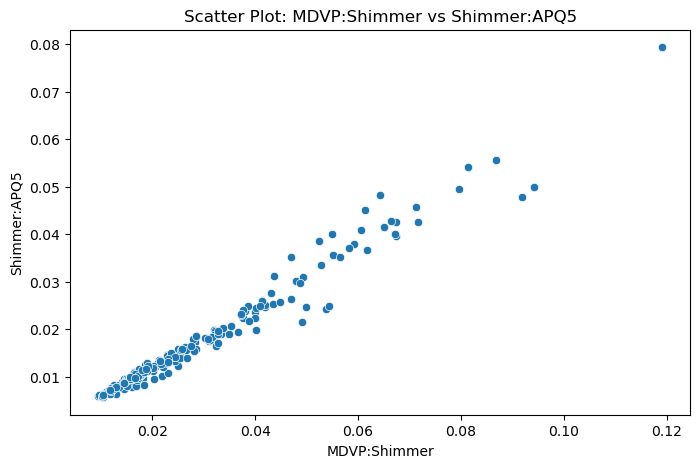

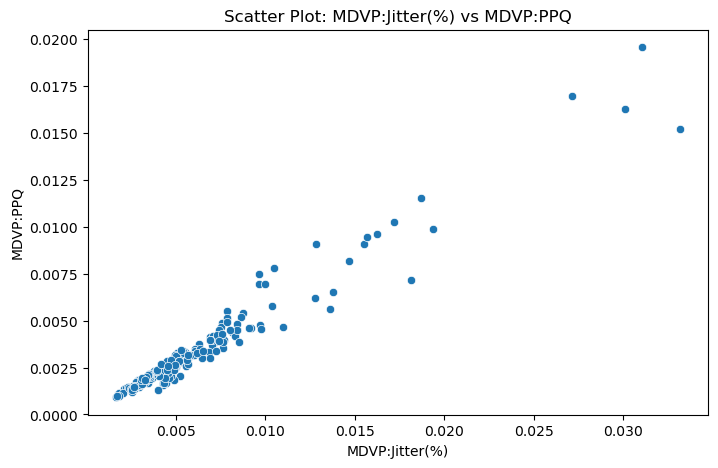

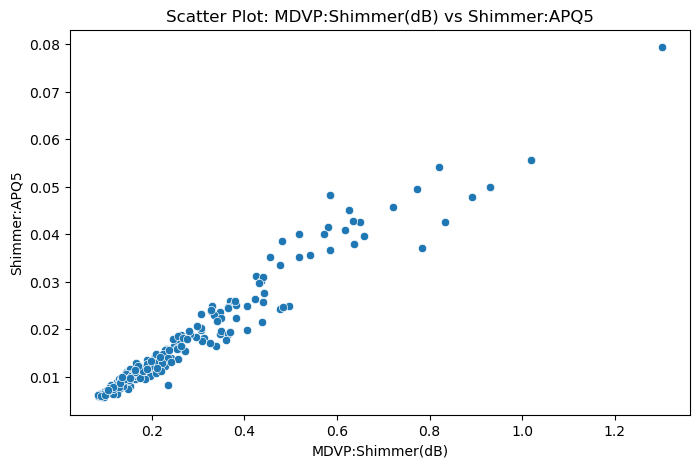

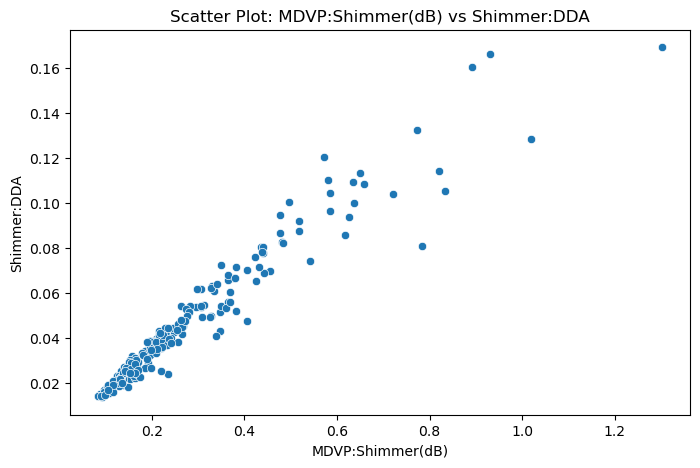

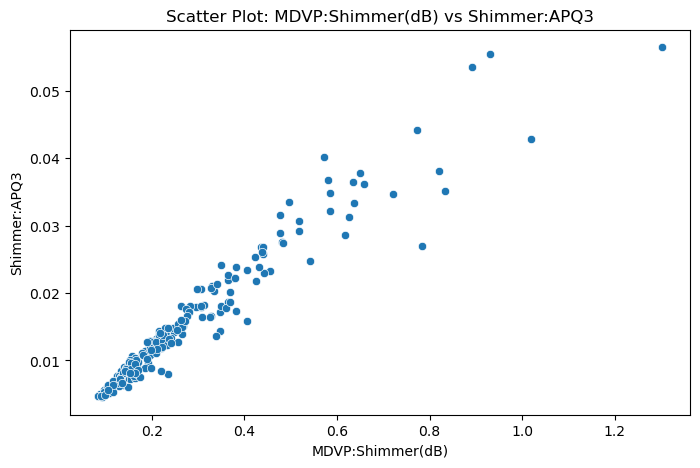

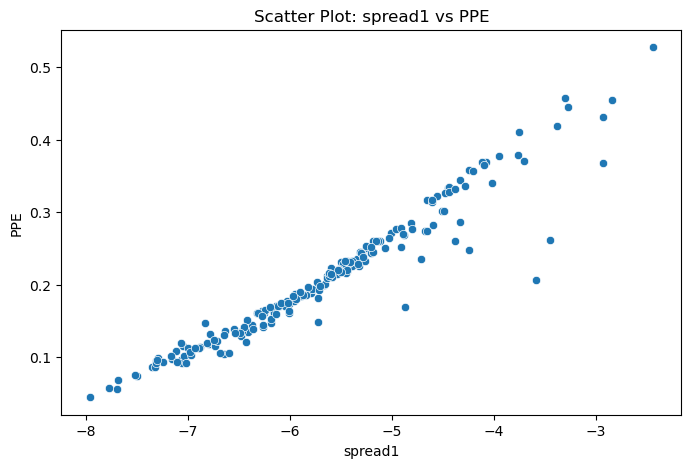

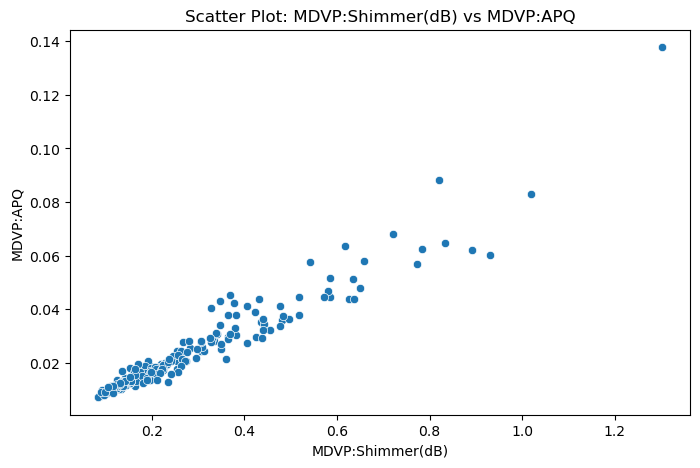

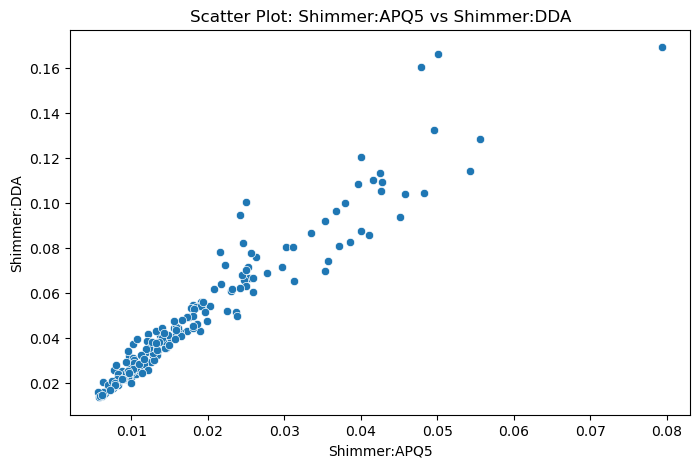

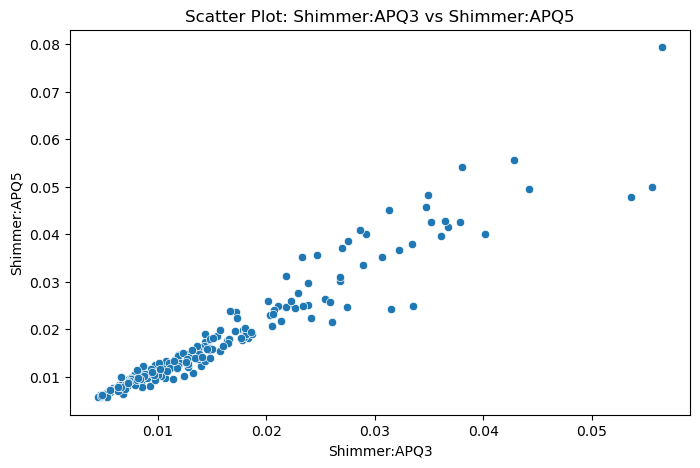

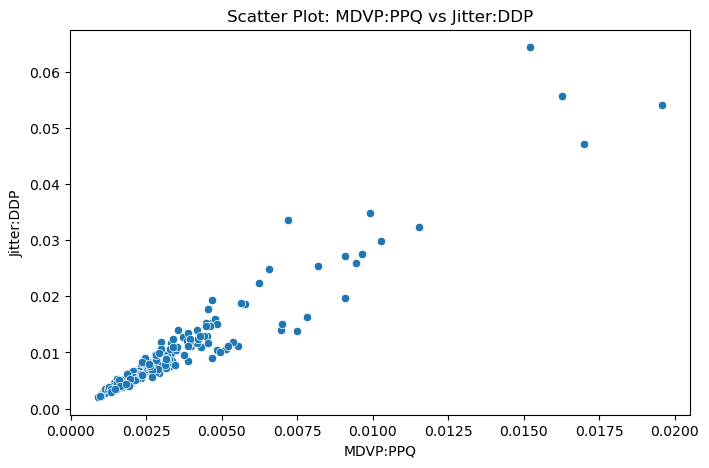

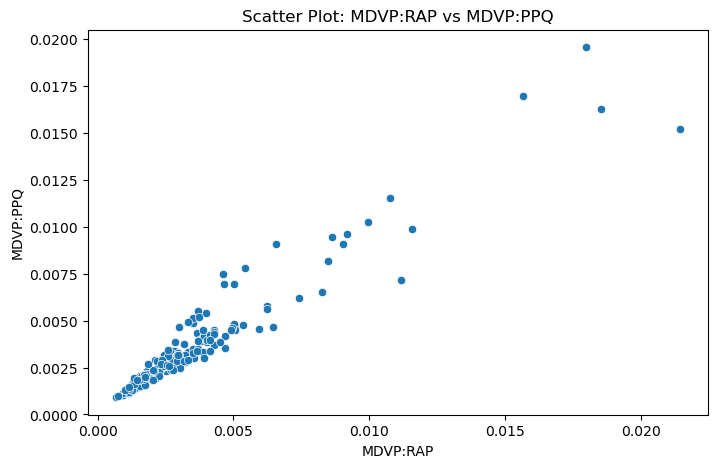

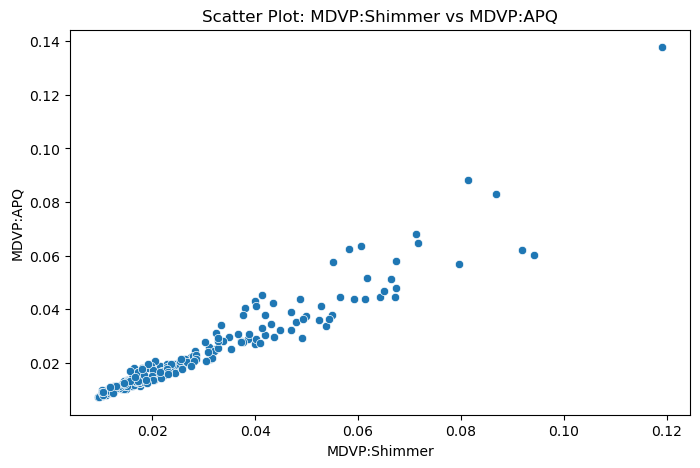

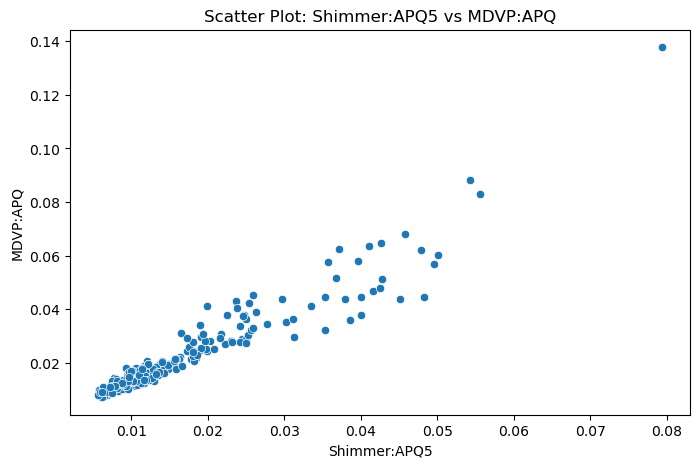

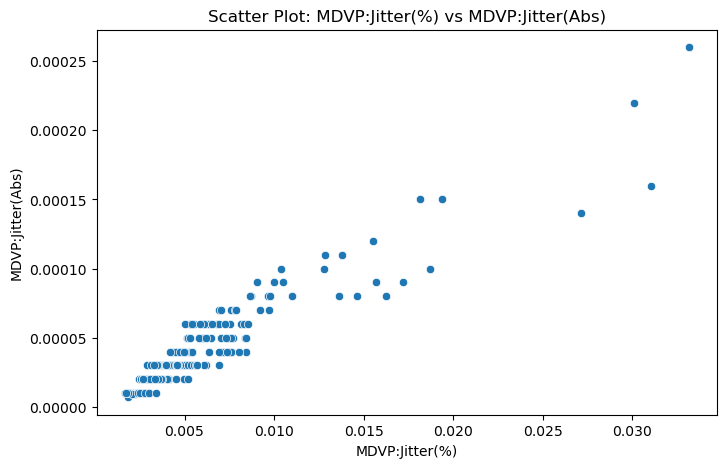

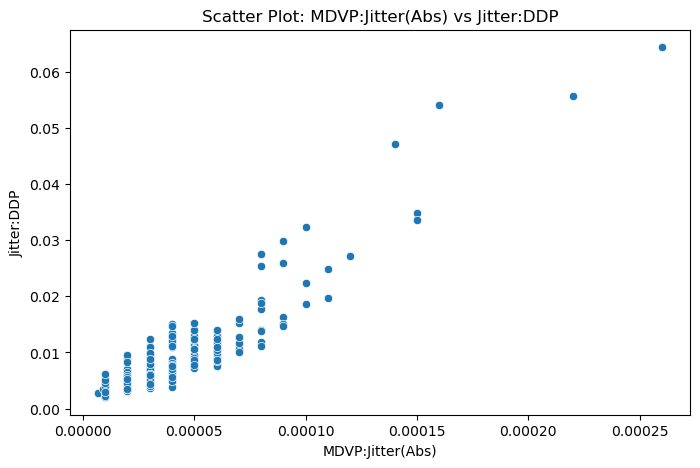

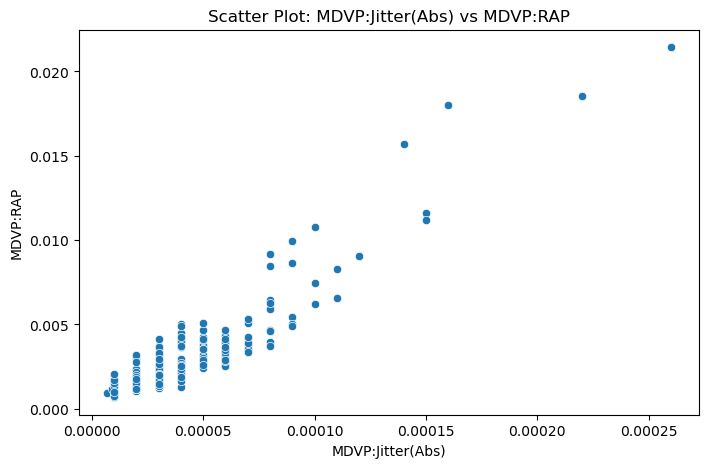

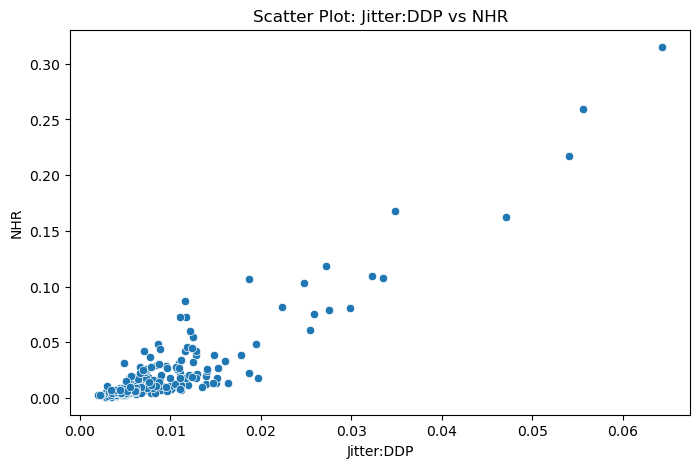

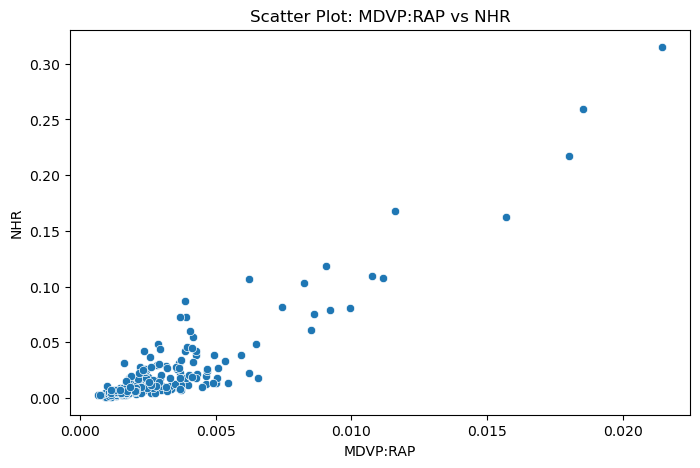

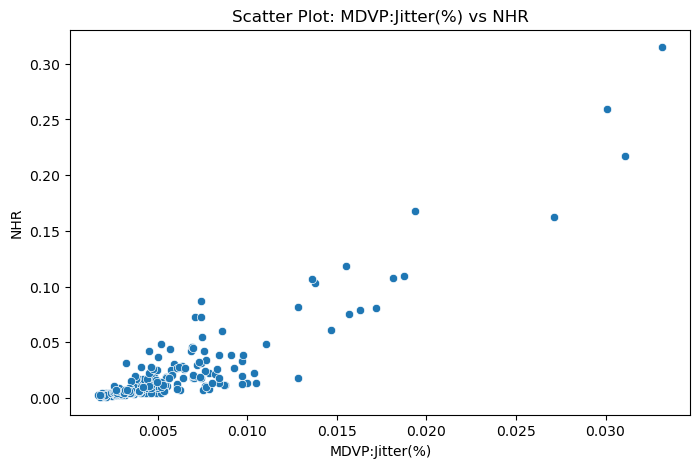

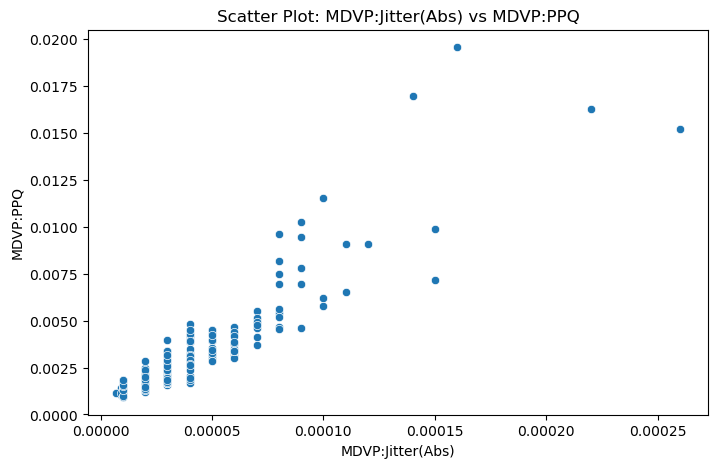

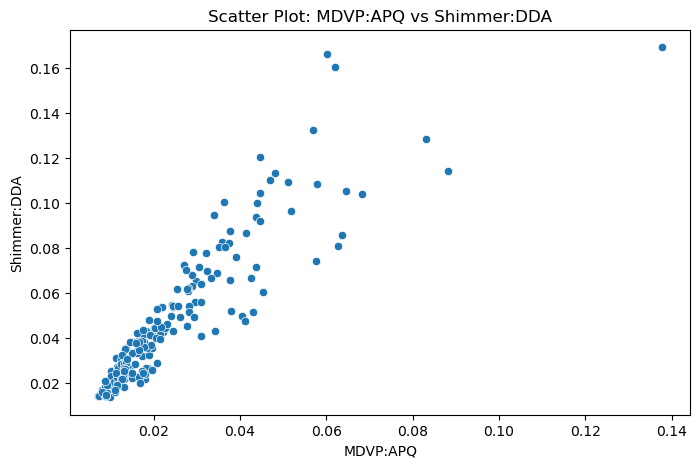

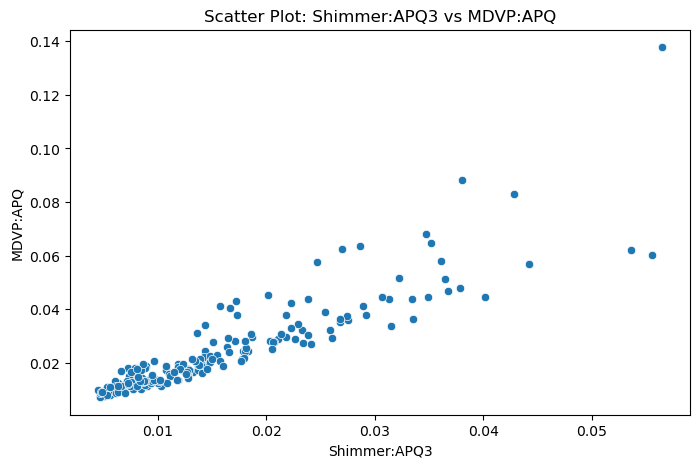

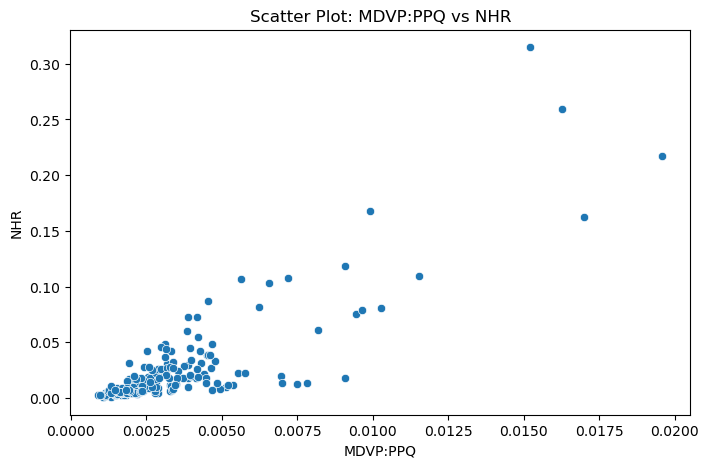

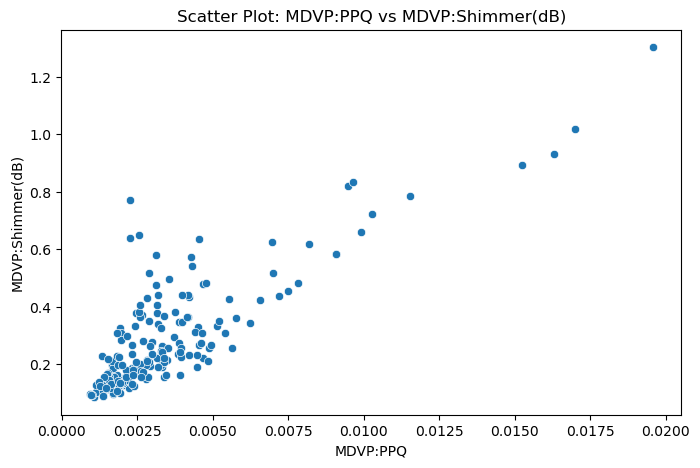

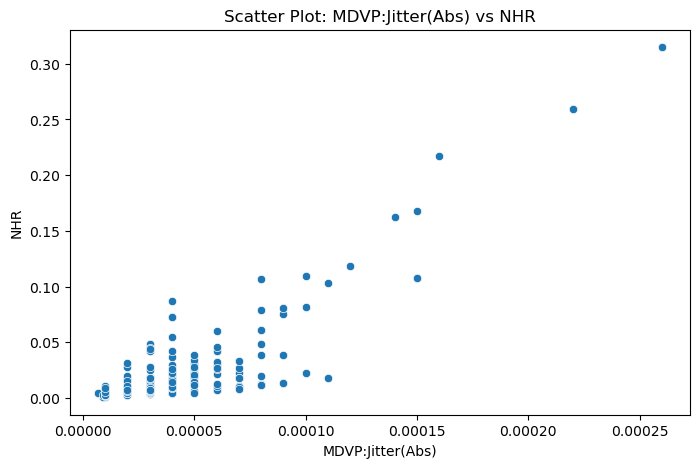

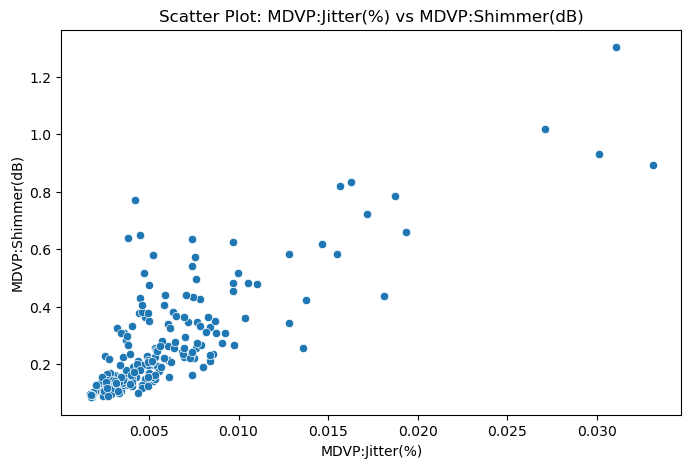

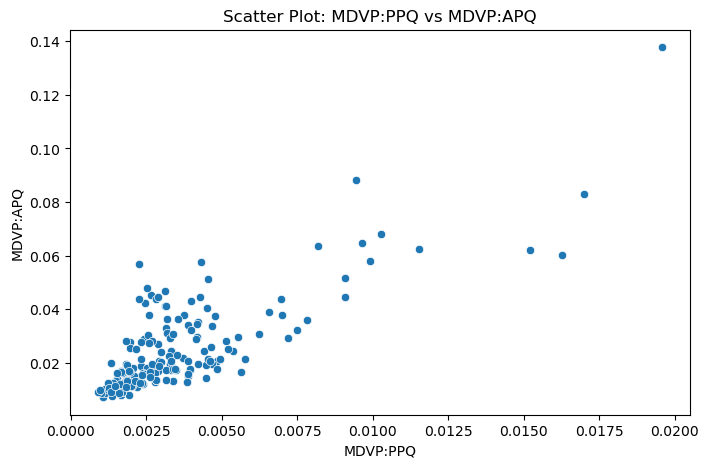

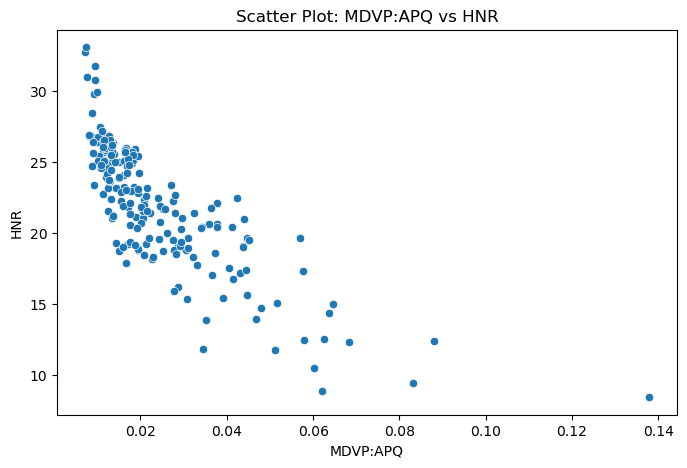

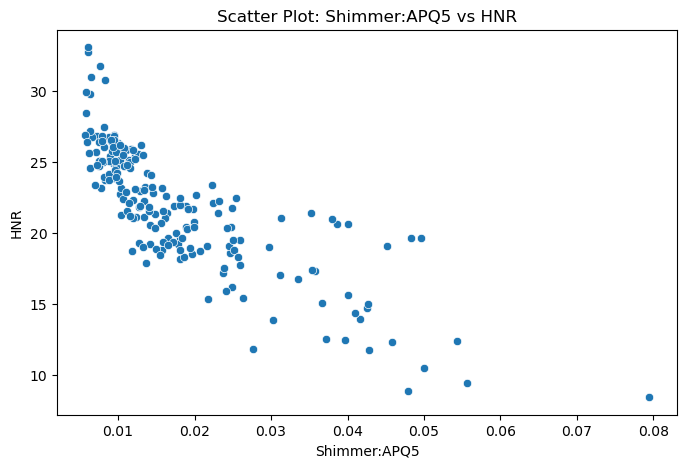

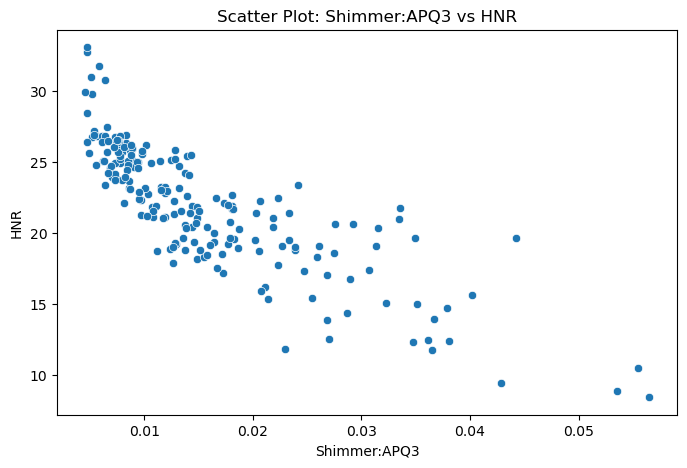

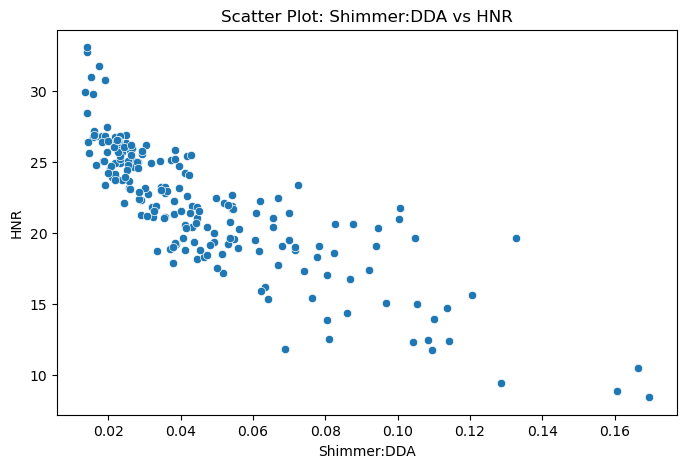

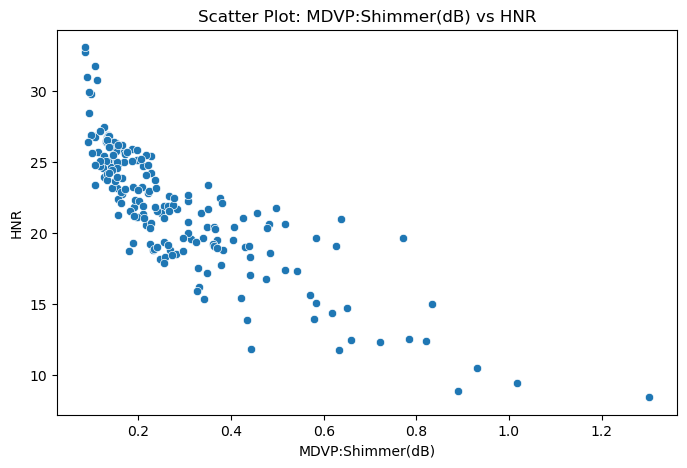

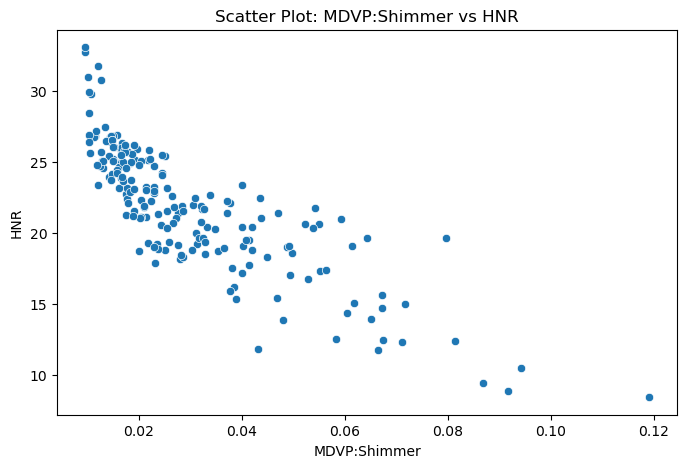

In [29]:
# Choose 0.8 as correlation threshold
correlation_threshold = 0.8

# Get highly correlated features
correlation_matrix = df.corr()
highly_correlated_features = (correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
                              .stack()
                              .sort_values(ascending=False)
                              .drop_duplicates())

highly_correlated_features = highly_correlated_features[abs(highly_correlated_features) > correlation_threshold]

# Visualize scatter plots for highly correlated features
for feature_pair in highly_correlated_features.index:
    feature1, feature2 = feature_pair
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x=feature1, y=feature2)
    plt.title(f'Scatter Plot: {feature1} vs {feature2}')
    plt.show()

Атрибутите кои имаат висока корелација носат иста или слична информација. Тоа може да доведе до: мултиколинеарност (ја нарушува стабилноста на модели како логистичка регресија), overfitting (претренираност на моделот, совршено совпаѓање на тренинг податоците), непотребна комплексност (без подобрување на перформансите). Поради тоа некои од атрибутите со висока корелација ќе ги отстранам.

In [32]:
columns_to_drop = [
    #Jitter група - околу фреквентистичка варијација - од оваа група задржуваме MDVP:Jitter(%)
    'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
    #Shimmer група - околу амплитудна варијација - од оваа група задржуваме само MDVP:Shimmer
    'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA',
    #Noise-to-Harmonics Ratio (NHR/HNR) - имаат силна негативна корелација - HNR (често е покорисен и помалку варијабилен)
    'NHR'
]

df = df.drop(columns=columns_to_drop)

Split the dataset

In [35]:
X = df.drop(['status'], axis=1)
y = df['status']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Logistic Regression

In [38]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Accuracy: 0.8974358974358975
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.89      1.00      0.94        32

    accuracy                           0.90        39
   macro avg       0.94      0.71      0.77        39
weighted avg       0.91      0.90      0.88        39



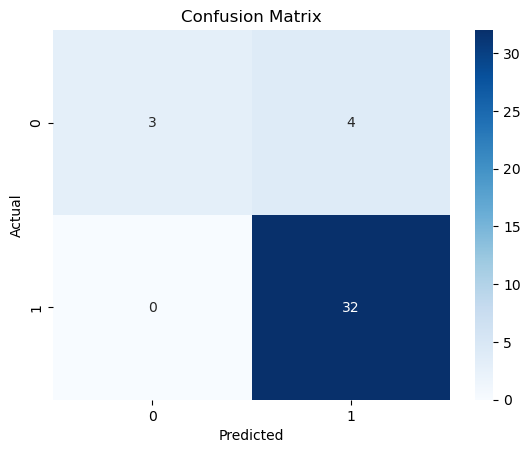

In [40]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

SVM

SVM Accuracy: 0.9230769230769231
SVM Report:
               precision    recall  f1-score   support

           0       1.00      0.57      0.73         7
           1       0.91      1.00      0.96        32

    accuracy                           0.92        39
   macro avg       0.96      0.79      0.84        39
weighted avg       0.93      0.92      0.91        39



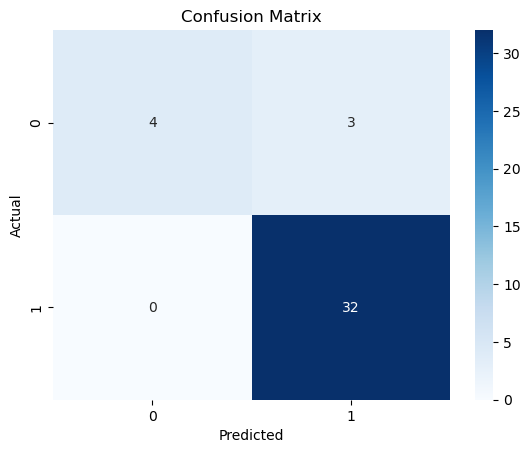

In [43]:
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print("SVM Report:\n", classification_report(y_test, svm_pred))

conf_matrix = confusion_matrix(y_test, svm_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Random Forest

Random Forest Accuracy: 0.9487179487179487
Random Forest Report:
               precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.94      1.00      0.97        32

    accuracy                           0.95        39
   macro avg       0.97      0.86      0.90        39
weighted avg       0.95      0.95      0.95        39



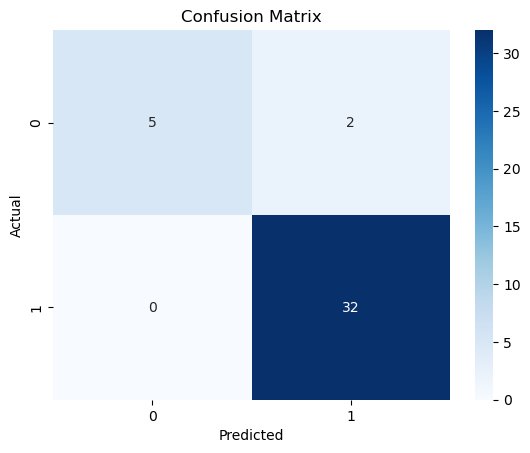

In [46]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print("Random Forest Report:\n", classification_report(y_test, rf_pred))

conf_matrix = confusion_matrix(y_test, rf_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

KNN

KNN Accuracy: 0.9487179487179487
KNN Report:
               precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.94      1.00      0.97        32

    accuracy                           0.95        39
   macro avg       0.97      0.86      0.90        39
weighted avg       0.95      0.95      0.95        39



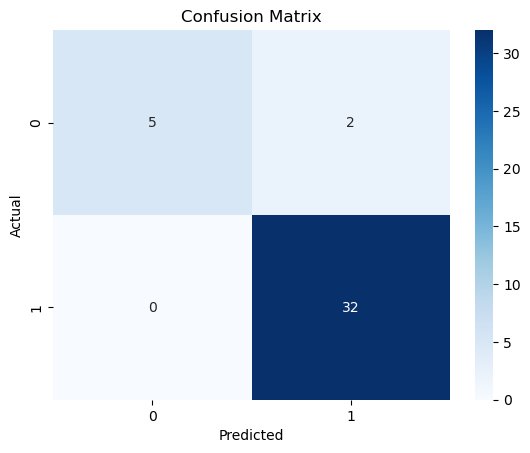

In [49]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, knn_pred))
print("KNN Report:\n", classification_report(y_test, knn_pred))

conf_matrix = confusion_matrix(y_test, knn_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Cross Validation

In [54]:
models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(kernel='rbf'),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

print("Cross-validation (5-fold):\n")
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=5)
    print(f"{name}: Accuracy = {scores.mean():.4f} ± {scores.std():.4f}")

Cross-validation (5-fold):

Logistic Regression: Accuracy = 0.8103 ± 0.0771
SVM: Accuracy = 0.8359 ± 0.0771
Random Forest: Accuracy = 0.8103 ± 0.0528
KNN: Accuracy = 0.8000 ± 0.0768
